# 📰 News Article Similarity Analysis using NLP 🧠📊

## 🎯 Objective
This notebook explores text similarity among news articles using NLP techniques. We will:

✅ Convert text into numerical vectors using pre-trained **GloVe embeddings**.  
✅ Reduce dimensionality for visualization using **PCA**.  
✅ Apply **K-Means clustering** to group similar news articles.  

---

## 🔍 Why GloVe?
GloVe (**Global Vectors for Word Representation**) provides **dense vector embeddings** trained on a large corpus, allowing us to capture the **semantic meaning** of words efficiently. 🏆✨  

Using GloVe, we can **transform text into meaningful numerical representations** for further processing and clustering. 🚀📖


In [1]:
# 📥 Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
# ⬇️ Download stopwords for text cleaning
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 📊 Data Overview
The dataset consists of news articles with the following columns:

📰 **title**: The headline of the news article.  
📄 **content**: The full text of the article.  

🎯 Our goal is to **analyze the similarity between articles** and **group them into clusters** for better understanding. 🔍🤖  


In [2]:

# download the dataset
!wget https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv


--2025-03-17 21:10:36--  https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18236066 (17M) [text/plain]
Saving to: ‘news_articles.csv’

news_articles.csv   100%[===================>]  17.39M  --.-KB/s    in 0.1s    

2025-03-17 21:10:37 (128 MB/s) - ‘news_articles.csv’ saved [18236066/18236066]



In [3]:
# Load dataset

# Load the dataset into a DataFrame
df = pd.read_csv("news_articles.csv")

# Display basic dataset information
print("📰 Dataset Information:")
print("======================")
print(f"Number of articles: {len(df)}")
print("\n📄 Columns:")
print(df.columns)
print("\n🔍 Sample Data:")
print(df.head())
print("\n📊 Missing Values:")
print(df.isnull().sum())
print("\n📈 Summary Statistics:")
print(df.describe())


📰 Dataset Information:
Number of articles: 55335

📄 Columns:
Index(['topic', 'headline', 'author', 'link', 'description', 'published date'], dtype='object')

🔍 Sample Data:
           topic                                           headline  \
0  entertainment  Will Smith Joins Diplo And Nicky Jam For The 2...   
1  entertainment    Hugh Grant Marries For The First Time At Age 57   
2  entertainment  Morgan Freeman 'Devastated' That Sexual Harass...   
3  entertainment  What To Watch On Amazon Prime That’s New This ...   
4  entertainment  Mike Myers Reveals He'd 'Like To' Do A Fourth ...   

            author                                               link  \
0    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
1       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/morgan-fr...   
3  Todd Van Luling  https://www.huffingtonpost.com/entry/amazon-pr...   
4    Andy McDonald  https://www.huf

## 🛠️ Text Preprocessing
✅ **Lowercasing** to standardize words. 🔡  
✅ **Removing special characters and punctuation** to clean the text. ✂️🧹  


In [5]:
# Handling missing values
df = df.dropna()  # Drop rows with missing values

# Text Cleaning Function
def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Remove non-word characters (punctuation, symbols, etc.)
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Apply the above function on the dataframe
df['title'] = df['headline'].apply(clean_text)
df['content'] = df['description'].apply(clean_text)

# Display cleaned data
print("🧹 Cleaned Data:")
print(df.head())



🧹 Cleaned Data:
           topic                                           headline  \
0  entertainment  Will Smith Joins Diplo And Nicky Jam For The 2...   
1  entertainment    Hugh Grant Marries For The First Time At Age 57   
2  entertainment  Morgan Freeman 'Devastated' That Sexual Harass...   
3  entertainment  What To Watch On Amazon Prime That’s New This ...   
4  entertainment  Mike Myers Reveals He'd 'Like To' Do A Fourth ...   

            author                                               link  \
0    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
1       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/morgan-fr...   
3  Todd Van Luling  https://www.huffingtonpost.com/entry/amazon-pr...   
4    Andy McDonald  https://www.huffingtonpost.com/entry/mike-myer...   

                                         description published date  \
0                           Of course it has a 

## 🏆 GloVe-Based Embeddings  
Each article is converted into a **100-dimensional numerical vector** using **GloVe embeddings**. 🔢✨  

🔹 If a word is **found** in GloVe, its corresponding **vector** is used. ✅  
🔹 If **no words** in an article match the GloVe vocabulary, a **zero vector** is assigned. ⚠️0️⃣  

Using these vectors, we can numerically represent text for further **analysis and clustering**. 📊🔍🚀  


In [9]:
# Download glove Embedding
import urllib.request
import os
import zipfile

url = 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip'
output = os.path.join(os.getcwd(), 'glove.6B.zip')  # Save to the current working directory

urllib.request.urlretrieve(url, output)

# Unzip the file
with zipfile.ZipFile('./glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('./glove')

# Load GloVe Embeddings
glove_path = "glove/glove.6B.100d.txt"  # Change if using a different version


In [10]:
# Load GloVe Embeddings
def load_glove_embeddings(glove_path):
    embeddings_dict = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype="float32")
            embeddings_dict[word] = vector
    return embeddings_dict

# Load GloVe embeddings
glove_path = "glove/glove.6B.100d.txt"  # Ensure this file exists
embeddings_dict = load_glove_embeddings(glove_path)

# Convert articles to vectors
def text_to_vector(text, embeddings_dict):
    tokens = text.split()  # Split text into words
    vectors = [embeddings_dict[word] for word in tokens if word in embeddings_dict]
    if len(vectors) == 0:
        return np.zeros(100)  # Return zero vector if no words are found in GloVe
    return np.mean(vectors, axis=0)  # Average word vectors to get the article vector

# Apply the function to the dataframe
df['title_vector'] = df['title'].apply(lambda x: text_to_vector(x, embeddings_dict))
df['content_vector'] = df['content'].apply(lambda x: text_to_vector(x, embeddings_dict))

# Display the first few rows with vectors
print("🔢 Article Vectors:")
print(df[['title', 'title_vector', 'content', 'content_vector']].head())



🔢 Article Vectors:
                                               title  \
0  will smith joins diplo and nicky jam for the 2...   
1    hugh grant marries for the first time at age 57   
2  morgan freeman devastated that sexual harassme...   
3  what to watch on amazon prime thats new this week   
4  mike myers reveals hed like to do a fourth aus...   

                                        title_vector  \
0  [-0.06183771, 0.21974994, 0.33516604, -0.48413...   
1  [0.09465719, 0.140305, 0.22294, -0.008487902, ...   
2  [0.1737558, 0.1335053, 0.05985401, -0.17544201...   
3  [-0.3344149, 0.020507904, 0.5776793, -0.171274...   
4  [-0.17235823, 0.04489067, 0.4320499, -0.457521...   

                                             content  \
0                            of course it has a song   
1  the actor and his longtime girlfriend anna ebe...   
2  it is not right to equate horrific incidents o...   
3        theres a great miniseries joining this week   
4  myers kids may be pushin

## ℹ️ Understanding PCA for Dimensionality Reduction  

### Why PCA? 🤔  
When working with **high-dimensional data**, it’s difficult to visualize and analyze patterns. **Principal Component Analysis (PCA)** helps by reducing the number of dimensions while **preserving important information**.  

### How Does It Work? ⚙️  
PCA transforms our **high-dimensional word embeddings** (100 dimensions) into **2 principal components** that capture most of the variance in the data. This allows us to **visualize articles in a 2D space**, making clustering more interpretable.  

🎯 **Goal:** Reduce dimensionality while retaining the most important information for better visualization and clustering.  
📊 **Next Step:** We’ll plot the articles in a 2D space to see if meaningful patterns emerge! 🚀  


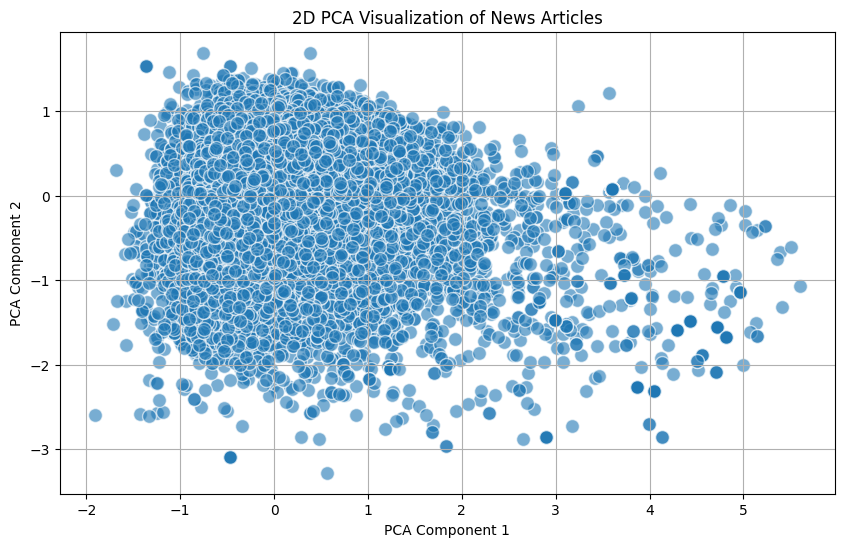

In [11]:
# Combine title and content vectors for dimensionality reduction
article_vectors = np.array(df['content_vector'].tolist())  # Use content vectors for analysis

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(article_vectors)

# Store in DataFrame
df['pca_x'] = X_pca[:, 0]
df['pca_y'] = X_pca[:, 1]

# Display the result in a 2D diagram
plt.figure(figsize=(10, 6))
plt.scatter(df['pca_x'], df['pca_y'], alpha=0.6, edgecolors='w', s=100)
plt.title("2D PCA Visualization of News Articles")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

## ℹ️ Understanding K-Means Clustering  

### Why Clustering? 🧐  
Once we have numerical representations of articles, we want to **group similar news articles together** based on their content. **K-Means clustering** is a powerful unsupervised learning algorithm that does exactly this!  

### How Does K-Means Work? ⚙️  
1️⃣ Choose the number of clusters (**k**)  
2️⃣ Assign each data point (news article) to the nearest cluster center  
3️⃣ Recalculate the cluster centers based on assigned points  
4️⃣ Repeat until cluster assignments stop changing  

### Choosing the Right k 📊  
We use the **Elbow Method** to find the **optimal number of clusters**. This helps prevent **overfitting** (too many clusters) or **underfitting** (too few clusters).  

🎯 **Goal:** Assign each article to a cluster and visualize the grouping! Let’s see if similar news topics naturally emerge. 🔍📰  


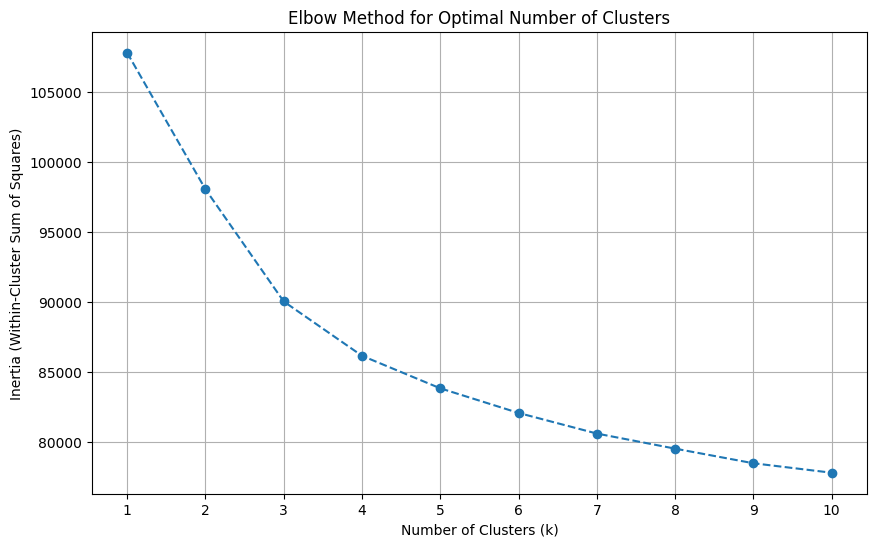

In [12]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 11)  # Test cluster numbers from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(article_vectors)
    inertia.append(kmeans.inertia_)  # Store the inertia (within-cluster sum of squares)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(K_range)
plt.grid(True)
plt.show()

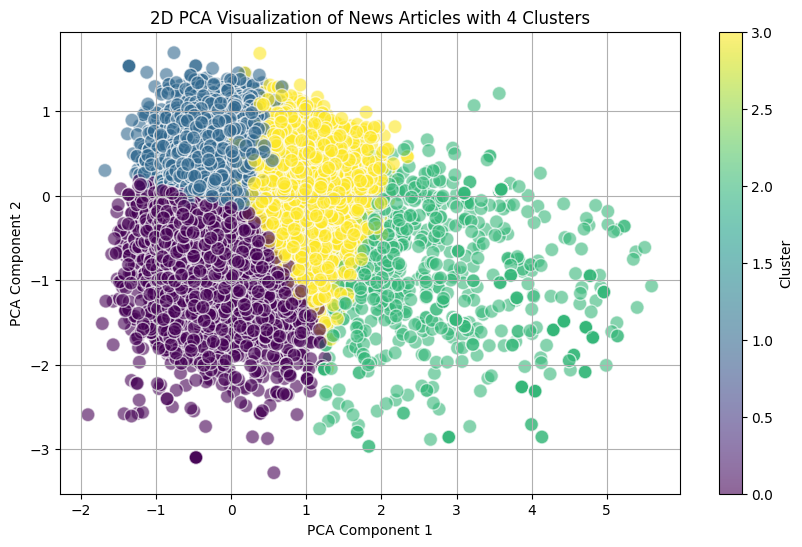

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply K-Means with optimal k (assumed to be 4)
optimal_k = 4  # Replace with the optimal k from the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(article_vectors)

# Visualize clusters in 2D PCA space
plt.figure(figsize=(10, 6))
plt.scatter(df['pca_x'], df['pca_y'], c=df['cluster'], cmap='viridis', alpha=0.6, edgecolors='w', s=100)
plt.title(f"2D PCA Visualization of News Articles with {optimal_k} Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


## ℹ️ Visualizing Clusters with Word Clouds  (Optional Section)

### Why Use Word Clouds? 🌥️🔠  
After clustering the news articles, it’s helpful to **understand the key themes** in each cluster. A **word cloud** is a simple but effective way to visualize the most common words in each group.  

### How Does It Work? ⚙️  
1️⃣ We **extract the text** from all articles in a cluster.  
2️⃣ We **count word frequencies**, giving more importance to frequently occurring words.  
3️⃣ A **word cloud** is generated, where **larger words** indicate higher frequency in that cluster.  

### What Can We Learn? 🤔  
- Identify **dominant keywords** in each cluster.  
- Get **insights into topic differences** between clusters.  
- Verify if our **K-Means clustering makes sense** based on meaningful word groupings.  

🎯 **Goal:** Use word clouds to quickly interpret the characteristics of each news category! ☁️📰🔍  


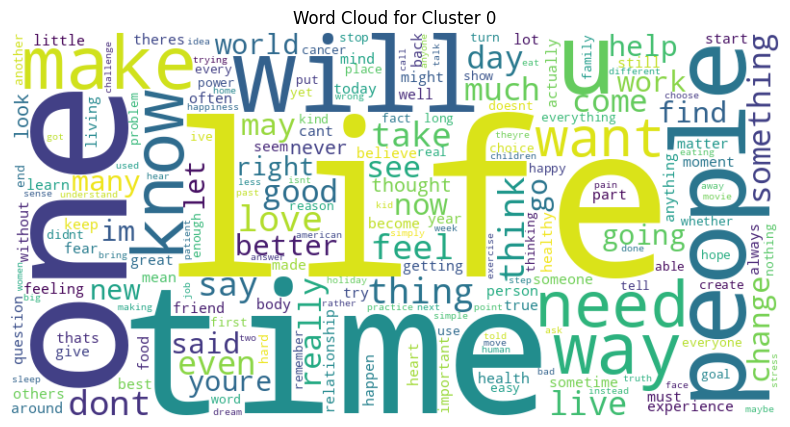

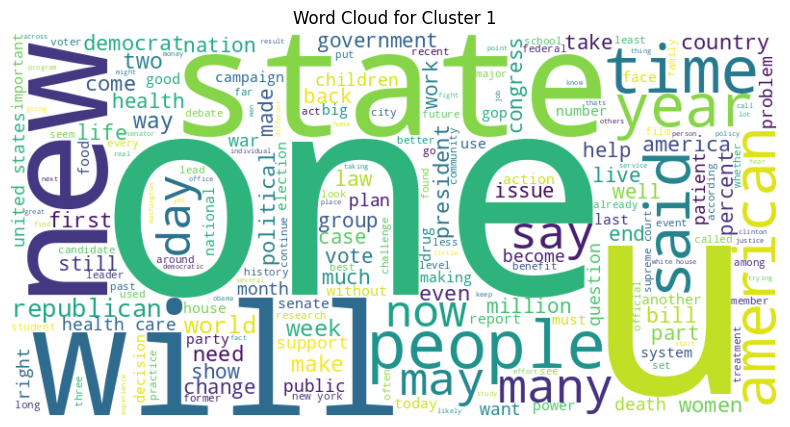

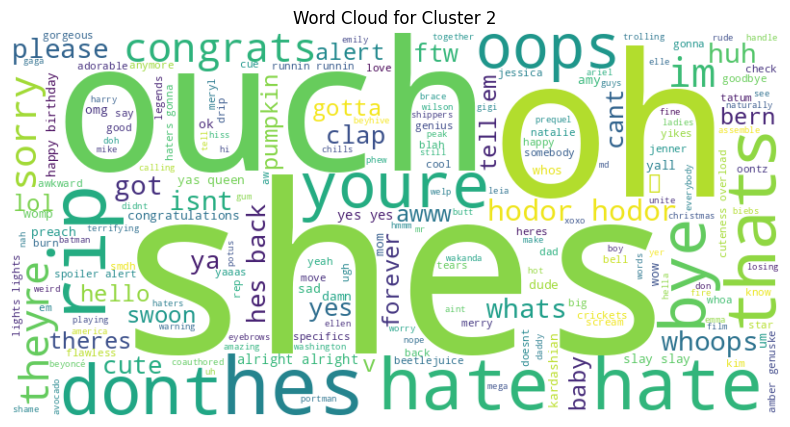

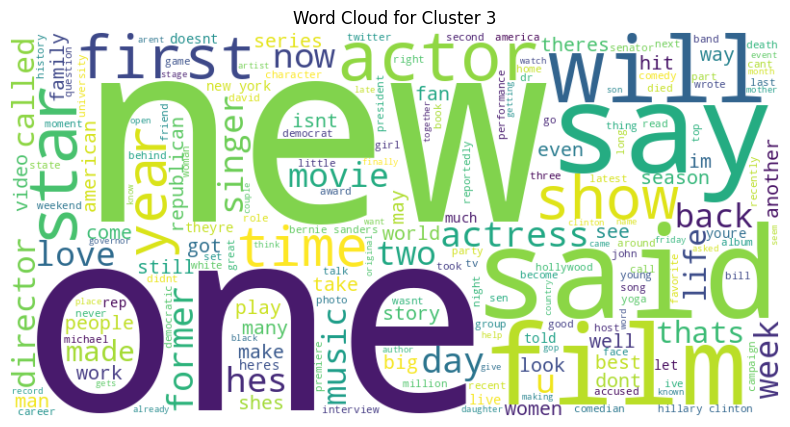

In [14]:
from wordcloud import WordCloud

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word cloud for each cluster
for cluster_id in range(optimal_k):
    cluster_text = ' '.join(df[df['cluster'] == cluster_id]['content'])  # Combine all content in the cluster
    generate_word_cloud(cluster_text, f"Word Cloud for Cluster {cluster_id}")


🧐 Critical Thinking & Discussion: Interpreting Our Results 💡📊📰

### 1️⃣ PCA Visualization Analysis
#### 🔍 Question:
Looking at the PCA Projection of News Articles, we see that the data is spread out but still has some overlapping areas.

- What does this distribution tell us about the underlying structure of the articles?
- Do you think reducing dimensionality to 2 components sufficiently preserves the key variations in the dataset? Why or why not?


### 2️⃣ Choosing the Optimal Number of Clusters
#### 📊 Question:
The Elbow Method plot suggests a decreasing trend in distortion as k increases.

- Based on the curve, what would you choose as the optimal k value?
- Why does the distortion decrease as k increases, and why shouldn’t we always choose a very high k?

### 3️⃣ Interpreting Clusters of News Articles
#### 📰 Question:
After applying K-Means clustering, the PCA-reduced plot shows four distinct clusters.

- How well-separated do the clusters appear? Do they seem meaningful?
- What possible themes might each cluster represent in terms of news content? How could we validate our assumptions about these themes?






